<center>
<img src="logo.png" height="900"> 
</center>

#  Поиск аномалий в данных 

__Тут выражается благодарность [Сергееву Дмитрию](https://github.com/DmitrySerg) за предоставленную тетрадку и собранный набор данных.__ 

В этой тетрадке мы поговорим про простейшие методы поиска аномалий в данных, основанные на описательных статистиках. 

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')  # стиль для графиков
%matplotlib inline

# Зачем вообще искать аномалии?

- Предобработка данных: убираем выбросы, чтобы не переобучиться
- Анализ выбросов: хотим найти, понять и обезвредить
- Поиск аномалий как самоцель (поиск мошенников, подозрительного поведения пользователей)

**Поиск аномалий** может быть как конечной целью анализа и построения моделей, так и промежуточным этапом подготовки и очистки данных. В первом сценарии мы хотим научиться для каждого объекта выборки выносить вердикт, является ли он аномальным/нестандартным, а во-втором мы находим и убираем выбросы в данных, чтобы в дальнейшем получить более устойчивые модели. 

В [определении](https://scikit-learn.org/stable/modules/outlier_detection.html) из документации scikit-learn, здача поиска аномалий разделяется на два возможных типа:

- **Outlier detection** (поиск выбросов): в тренировочной выборке содержатся выбросы, которые определяются как наблюдения, лежащие далеко от остальных. Таким образом, алгоритмы для детектирования выбросов пытаются найти регионы, где сосредоточена основная масса тренировочных данных, игрорируя аномальные наблюдения.
- **Novelty detection** (поиск "новизны"): тренировочная выборка не загрязнена выбросами, и мы хотим научиться отвечать на вопрос "является ли новое наблюдение выбросом". 


## Сложности при поиске аномалий

На практике задача поиска аномалий зачастую не сводится к построению бинарного классификатора "выброс/не выброс". Реальные данные редко бывают размечены и мы вынуждены использовать методы обучения без учителя. 

Одновременно с этим возникает вопрос о построении надежной схемы проверки результатов, ведь если "правильных ответов" у нас нет, то и понять, насколько алгоритм справляется со своей задачей, уже сложнее. Здесь очень помогут экспертные оценки о проценте аномальных объектов, которые ожидаются в выборке, так как с ними можно будет сравнивать прогнозные значения и варьировать тем самым чувствительность алгоритмов. 

Если же поиск и очистка от аномалий - это шаг в подготовке данных для последующего моделирования, то можно использовать стандартные подходы из машинного обученияб, о которых речь пойдёт на будующих неделях нашей специализации. 

# 1. Данные 

Снова воспользуемся данными по мемам. 

In [2]:
df = pd.read_csv('memes_prepare.csv', sep='\t')
df.set_index('name', inplace=True)

# возьмём только числовые колонки
df = df[['views', 'photos', 'comments', 'days_from_creation', 
          'average_views', 'average_comments', 'tags_len' ]]
df.head()

,views,photos,comments,days_from_creation,average_views,average_comments,tags_len
name,,,,,,,
Muvvafukka,13613,7,8,13.478206,940.240799,0.552555,197.0
Martyrdom (Drop a Live Grenade When Killed),13973,17,8,14.139201,922.968104,0.528429,102.0
Wet Kylo Ren,5339,12,7,14.150937,352.387435,0.462018,130.0
You're Invited,2249,0,0,14.209444,147.868649,0.000000,38.0
Companies Posting Their Own Names,5662,16,33,12.118958,431.589144,2.515444,200.0


__Описание колонок:__

- `name` - название мема
- `views` - число просмотров на сайте
- `comments` - число комментариев
- `photos` - число вкладышей с мемом 
- `days_from_creation` - сколько дней прошло от появления мема
- `average_views` - среднее число просмотров за день
- `average_comments` - среднее число комментариев за день
- `tags_len` - длина тегов в описании в числе символов

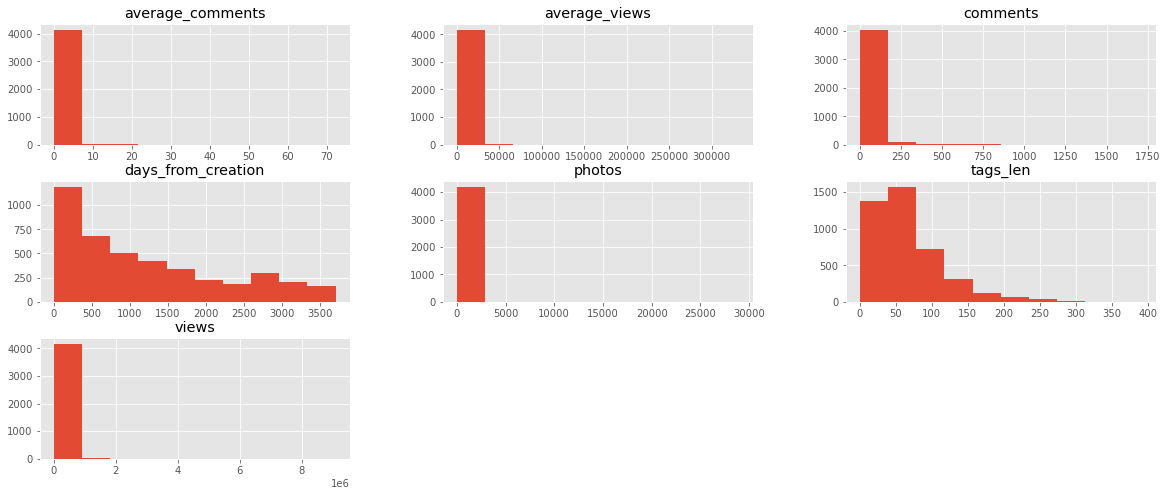

In [3]:
df.hist(figsize=(20, 8));

Прологарифмируем все переменные с длинными хвостами, чтобы на визуализациях аномалий можно было их увидеть. 

In [4]:
for var in ['views', 'photos', 'average_views', 
            'average_comments', 'comments']:
    df[var] = df[var].apply(lambda w: np.log(w + 1))

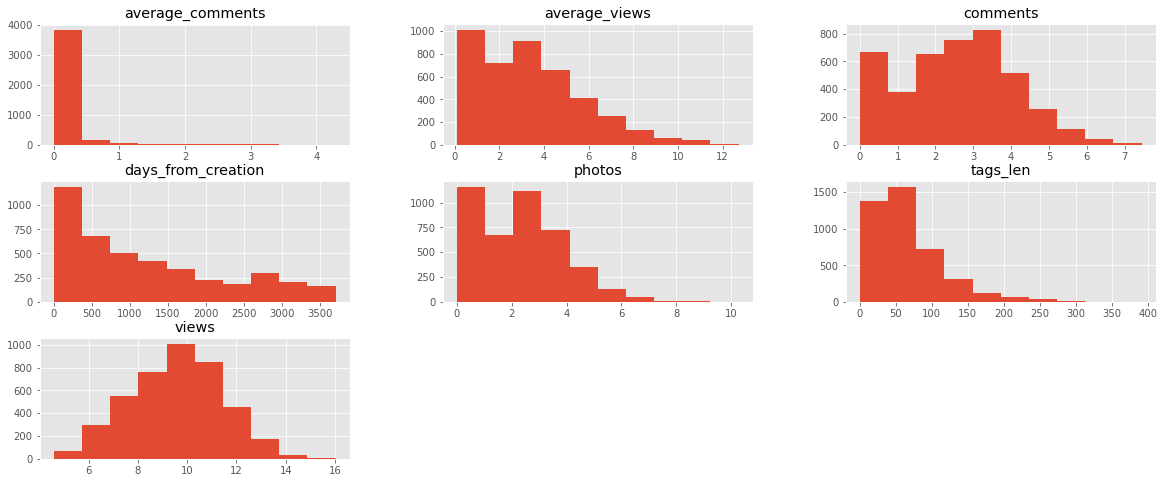

In [5]:
df.hist(figsize=(20, 8));

Мы видим, что даже после логарифмирования часть хвостов остались тяжёлыми. Давайте попробуем найти все аномальные мемы, лежащие в этих хвостах хотябы по одному из признаков. 

# 2. Методы на основе описательных статистик


## 2.1  Правило 3-х сигм 

Всё, что оказалось за пределами трёх сигм - аномалия. 

In [6]:
def outlier_std(data, col, threshold=3):
    """
        Вычисляет для каждой строки является ли она аномалией
    """
    
    mean = data[col].mean()
    std = data[col].std()
    
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    
    anomalies = pd.concat([data[col] > up_bound, data[col] < low_bound], axis=1).any(axis=1)
    return anomalies, up_bound, low_bound

In [7]:
a,l,r = outlier_std(df, df.columns)
l

views                   15.185193
photos                   7.225498
comments                 7.051274
days_from_creation    4313.298348
average_views           10.518375
average_comments         1.436078
tags_len               208.228516
dtype: float64

In [8]:
def get_column_outliers(data, function=outlier_std, threshold=3):
       
    # дополнительная колонка с отметкой является ли конкретное наблюдение аномалией
    outliers = pd.Series(data=[False]*len(data), index=data.index, name='is_outlier')
    
    # табличка для статистики по каждой колонке
    comparison_table = {}
    
    for column in data.columns:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers.loc[anomalies[anomalies].index] = True    
        
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    return comparison_table, outliers

In [9]:
comparison_table, std_outliers = get_column_outliers(df)

# статистика по каждой колонке и числу аномалий в ней
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
views,15.185193,3.980612,2.0,0.047551
photos,7.225498,-2.782073,13.0,0.309082
comments,7.051274,-1.882095,5.0,0.118878
days_from_creation,4313.298348,-1922.649473,0.0,0.000000
average_views,10.518375,-3.710159,38.0,0.903471
average_comments,1.436078,-1.129207,116.0,2.757965
tags_len,208.228516,-77.210922,78.0,1.854494


In [10]:
# какие наблюдения являются аномалиями, а какие нет 
std_outliers

name
Muvvafukka                                     False
Martyrdom (Drop a Live Grenade When Killed)    False
Wet Kylo Ren                                   False
You're Invited                                 False
Companies Posting Their Own Names              False
                                               ...  
In G Major                                     False
Blood Diamond Pants                            False
Because of Parkinson's                         False
Paranoid Parrot                                 True
I Believe You Have My Stapler                  False
Name: is_outlier, Length: 4206, dtype: bool

In [11]:
def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))    

In [12]:
anomalies_report(std_outliers)

Total number of outliers: 197
Percentage of outliers:   4.68%


In [13]:
labeled_df = df.copy()
labeled_df['is_outlier'] = std_outliers

In [14]:
labeled_df.head()

,views,photos,comments,days_from_creation,average_views,average_comments,tags_len,is_outlier
name,,,,,,,,
Muvvafukka,9.518854,2.079442,2.197225,13.478206,6.847199,0.439902,197.0,False
Martyrdom (Drop a Live Grenade When Killed),9.544954,2.890372,2.197225,14.139201,6.828678,0.424241,102.0,False
Wet Kylo Ren,8.582981,2.564949,2.079442,14.150937,5.867565,0.379817,130.0,False
You're Invited,7.718685,0.000000,0.000000,14.209444,5.003064,0.000000,38.0,False
Companies Posting Their Own Names,8.641709,2.833213,3.526361,12.118958,6.069788,1.257166,200.0,False


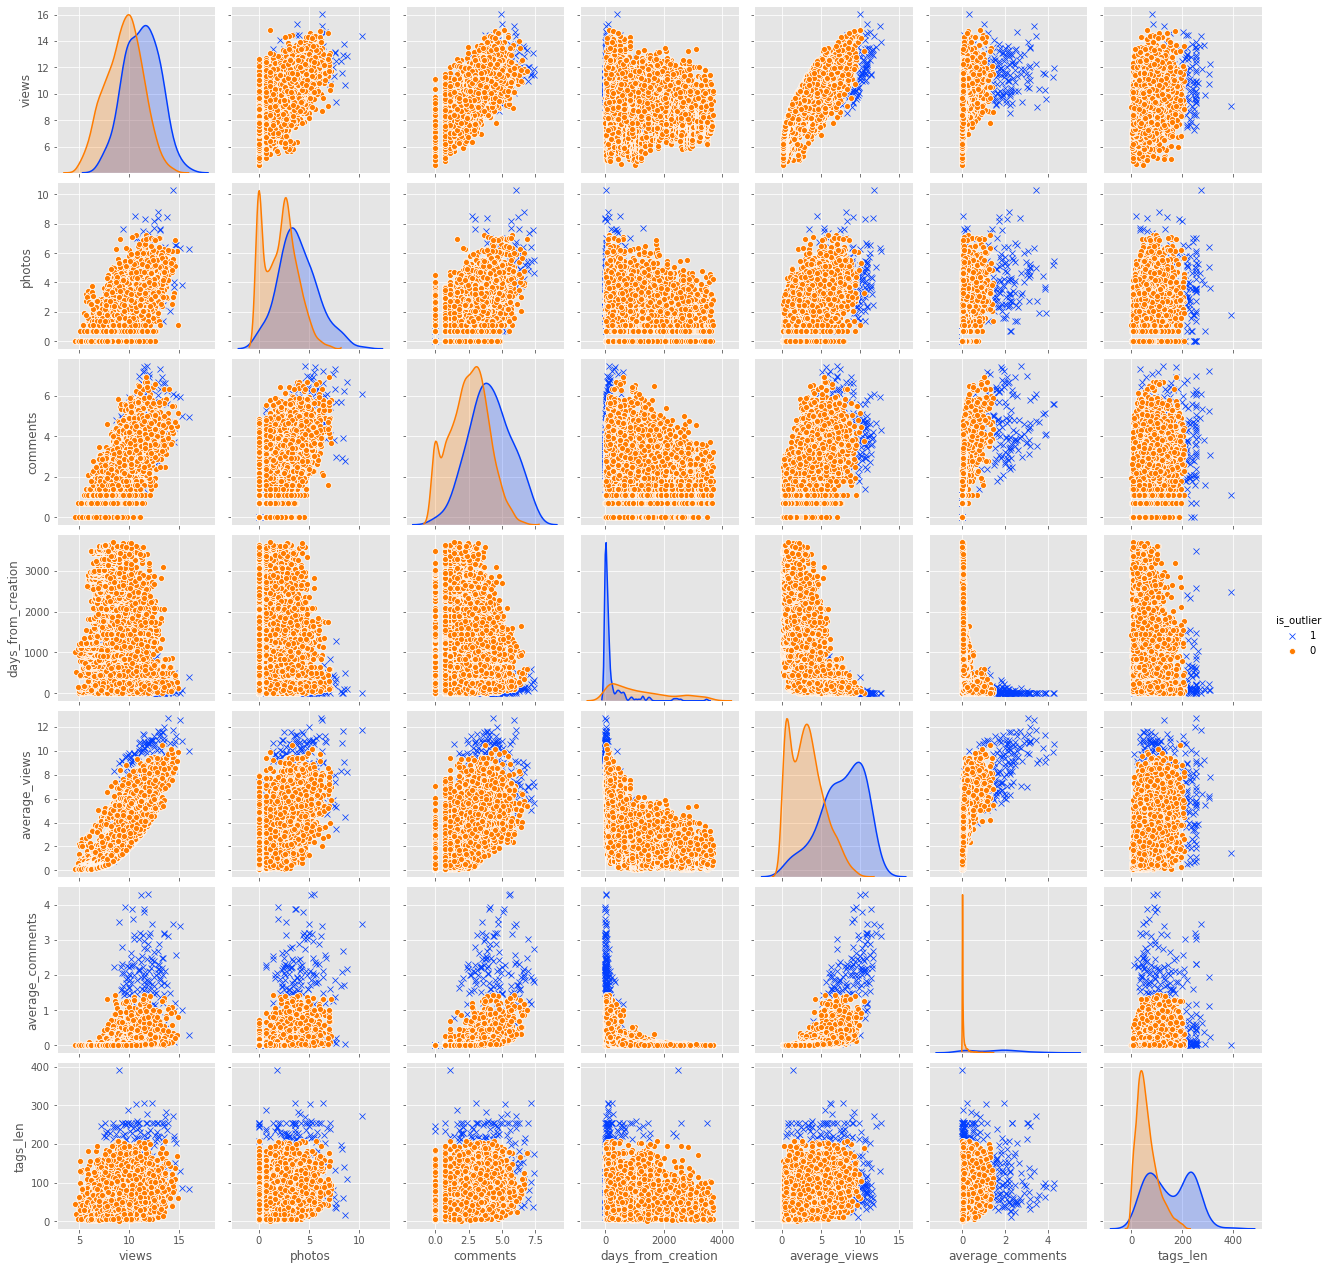

In [15]:
sns.pairplot(data=labeled_df, vars=df.columns,
             hue='is_outlier', hue_order=[1, 0],
             markers=['x', 'o'],  palette='bright');

## 2.2  Межквартильное отклонение

Всё, что оказалось за пределами трёх межквартильных отклонений - аномалия. 

In [16]:
def outlier_iqr(data, col, threshold = 3):
    
    # интерквантильный размах
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    
    # насколько размахов отступать 
    up_bound = data[col].quantile(0.75) + (IQR * threshold)
    low_bound = data[col].quantile(0.25) - (IQR * threshold)
    
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(axis=1)
    return anomalies, up_bound, low_bound

In [17]:
comparison_table, iqr_outliers = get_column_outliers(df, function=outlier_iqr)
anomalies_report(iqr_outliers)

Total number of outliers: 459
Percentage of outliers:   10.91%


In [18]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
views,18.752140,0.395261,0.0,0.000000
photos,11.103906,-7.114922,0.0,0.000000
comments,9.587959,-4.374453,0.0,0.000000
days_from_creation,6755.824809,-4574.705787,0.0,0.000000
average_views,14.986661,-8.717863,0.0,0.000000
average_comments,0.328956,-0.242357,443.0,10.532573
tags_len,245.000000,-126.000000,35.0,0.832145


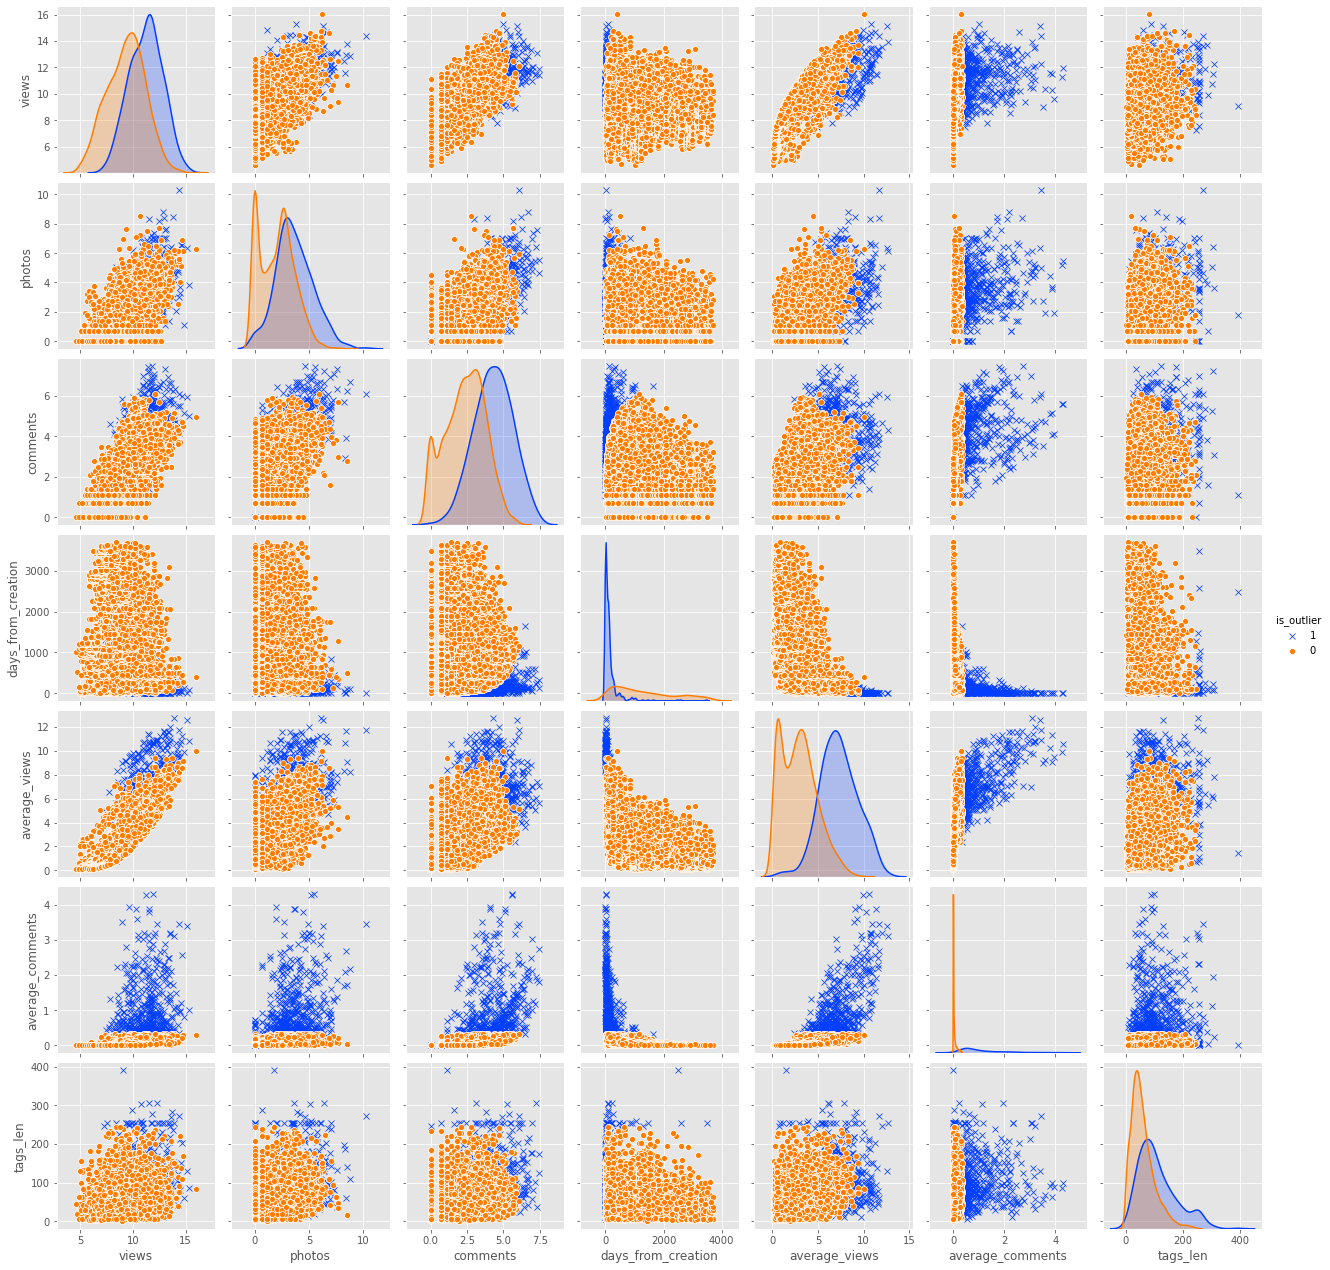

In [19]:
labeled_df = df.copy()
labeled_df['is_outlier'] = iqr_outliers

sns.pairplot(data=labeled_df, vars = df.columns,
             hue='is_outlier', hue_order=[1, 0],
             markers=['x', 'o'],  palette='bright');

Кроме простых методов, основанных на описательных статистиках есть много методов, основанных на машинном обучении. __Примеры их использования ищите [в расширенной версии этой тетрадки.](https://github.com/DmitrySerg/otus-public/blob/master/OpenLessons/AnomalyDetection/AnomalyDetection_OpenLesson.ipynb)__  

![](https://i.pinimg.com/originals/e5/c4/0d/e5c40dd06a9cdda2ac88101897606543.gif)